In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score
from scipy.stats import rankdata
import itertools
from functools import partial

In [3]:
from pygraphs.cluster import KKMeans_vanilla as KKMeans
from pygraphs.graphs.generator import StochasticBlockModel, RubanovModel
from pygraphs.measure import *
from pygraphs.measure.kernel import Kernel
from pygraphs.measure import kernels, scaler
from pygraphs.scenario import plot_results, d3_colors, ParallelByGraphs
from pygraphs.scorer import rand_index

In [4]:
optimal_params_KKMeans = {  # for (100, 2, 0.3, 0.15)
    'pWalk': 0.77,
    'Walk': 0.12,
    'For': 0.81,
    'logFor': 0.04,
    'Comm': 0.29,
    'logComm': 0.58,
    'Heat': 0.60,
    'logHeat': 0.13,
    'NHeat': 0.93,
    'logNHeat': 0.97,
    'SCT': 0.95,
    'SCCT': 0.91,
    'RSP': 0.73,
    'FE': 0.34,
    'PPR': 0.98,
    'logPPR': 0.36,
    'ModifPPR': 0.96,
    'logModifPPR': 0.36,
    'HeatPPR': 0.97,
    'logHeatPPR': 0.80,
    'SP-CT': 0.88
}

# Combinations

In [5]:
graphs, _ = StochasticBlockModel(100, 2, p_in=0.3, p_out=0.15).generate_graphs(100)

In [6]:
def SCCT_getK(A):
    measure = SCCT_H(A)
    SCCT_param = measure.scaler.scale(optimal_params_KKMeans['SCCT'])
    return measure.get_K(SCCT_param)

def logComm_getK(A):
    measure = logComm_H(A)
    logComm_param = measure.scaler.scale(optimal_params_KKMeans['logComm'])
    return measure.get_K(logComm_param)

def HeatPPR_getK(A):
    measure = HeatPPR_H(A)
    HeatPPR_param = measure.scaler.scale(optimal_params_KKMeans['HeatPPR'])
    return measure.get_K(HeatPPR_param)

def logNHeat_getK(A):
    measure = logNHeat_H(A)
    logNHeat_param = measure.scaler.scale(optimal_params_KKMeans['logNHeat'])
    return measure.get_K(logNHeat_param)

measure_getK = {
    'SCCT': SCCT_getK,
    'logComm': logComm_getK,
    'HeatPPR': HeatPPR_getK,
    'logNHeat': logNHeat_getK
}

In [17]:
all_results = {}

def pair_measure_builder(measure1, measure2):

    class pair_measure(Kernel):
        name, default_scaler = f'{measure1.name}-{measure2.name}', scaler.Linear

        def __init__(self, A):
            super().__init__(A)

            self.measure1_result = measure_getK[measure1.name](A)
            self.measure2_result = measure_getK[measure2.name](A)

        def get_K(self, param):
            return (1 - param) * self.measure1_result + param * self.measure2_result
        
    return pair_measure

for measure1, measure2 in tqdm([
        (SCCT_H, logComm_H),
        (SCCT_H, HeatPPR_H),
        (SCCT_H, logNHeat_H),
        (logComm_H, HeatPPR_H),
        (logComm_H, logNHeat_H),
        (HeatPPR_H, logNHeat_H)]):

    measure = pair_measure_builder(measure1, measure2)
    classic_plot = ParallelByGraphs(rand_index, 151, progressbar=True, verbose=True)
    results_pair = classic_plot.perform(KKMeans, measure, graphs, 2, n_jobs=6)

    all_results[measure.name] = results_pair

HeatPPR-logNHeat: 100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


In [18]:
for measure1, measure2 in tqdm([
        (SCCT_H, SCCT_H),
        (logComm_H, logComm_H),
        (HeatPPR_H, HeatPPR_H),
        (logNHeat_H, logNHeat_H)]):
    measure = pair_measure_builder(measure1, measure2)
    classic_plot = ParallelByGraphs(rand_index, 1, progressbar=True, verbose=True)
    results_pair = classic_plot.perform(KKMeans, measure, graphs, 2, n_jobs=6)

    all_results[measure.name] = results_pair

logNHeat-logNHeat: 100%|██████████| 100/100 [00:01<00:00, 95.94it/s]


In [50]:
data = np.full((4, 4), np.nan)

for idx1, measure1 in enumerate([SCCT_H, logComm_H, HeatPPR_H, logNHeat_H]):
    for idx2, measure2 in enumerate([SCCT_H, logComm_H, HeatPPR_H, logNHeat_H]):
        try:
            key = f'{measure1.name}-{measure2.name}'
            x, y, error = all_results[key]
            max_ari = np.nanmax(y)
            print(key, f'{max_ari:.4f}')
            
            data[idx1, idx2] = max_ari
        except:
            pass

SCCT-SCCT 0.8791
SCCT-logComm 0.8798
SCCT-HeatPPR 0.8797
SCCT-logNHeat 0.8796
logComm-logComm 0.8761
logComm-HeatPPR 0.8816
logComm-logNHeat 0.8779
HeatPPR-HeatPPR 0.8765
HeatPPR-logNHeat 0.8765
logNHeat-logNHeat 0.8742


In [51]:
data

array([[0.87909293, 0.87978182, 0.87965657, 0.87957172],
       [       nan, 0.87609697, 0.88163232, 0.87792727],
       [       nan,        nan, 0.87653535, 0.87653535],
       [       nan,        nan,        nan, 0.87419394]])

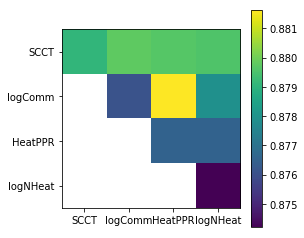

In [58]:
fig, ax = plt.subplots(1, figsize=(4, 4))

# heatmap = ax.pcolor(data)

ax.imshow(data)

ax.set_yticks(range(4))
ax.set_xticks(range(4));

ax.set_yticklabels(['SCCT', 'logComm', 'HeatPPR', 'logNHeat'])
ax.set_xticklabels(['SCCT', 'logComm', 'HeatPPR', 'logNHeat']);


plt.colorbar(heatmap)

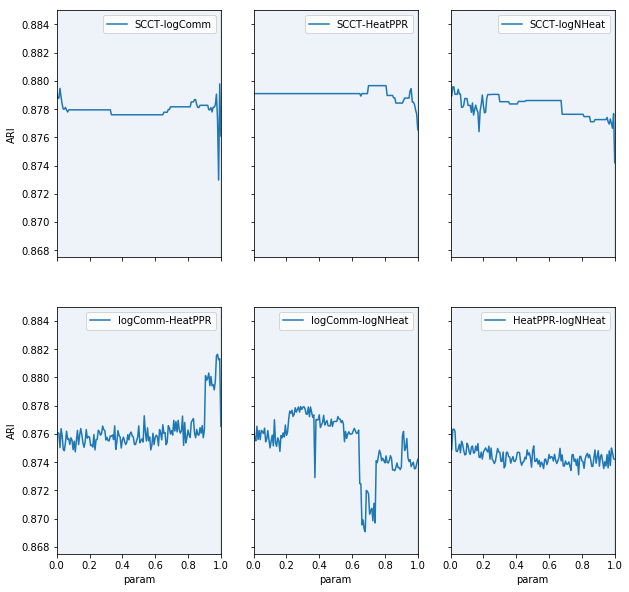

In [76]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10), sharex=True, sharey=True)

    
for idx, (measure1, measure2) in enumerate([
        (SCCT_H, logComm_H),
        (SCCT_H, HeatPPR_H),
        (SCCT_H, logNHeat_H),
        (logComm_H, HeatPPR_H),
        (logComm_H, logNHeat_H),
        (HeatPPR_H, logNHeat_H)]):
    key = f'{measure1.name}-{measure2.name}'
    x, y, error = all_results[key]
    
    plot_results(ax[idx // 3][idx % 3], [(key, *all_results[key])], ylim=(0.8675, 0.885))
    if idx // 3 == 1:
        ax[idx // 3][idx % 3].set_xlabel('param')
    if idx % 3 == 0:
        ax[idx // 3][idx % 3].set_ylabel('ARI')